In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install torchviz
! pip install torchsummary
! pip install imblearn
!pip install efficientnet_pytorch
!pip install ultralytics
! pip install split-folders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:

#if you dont have dataset, you can download that from kaggle
import os
import kagglehub
import shutil



# Define the paths for the new directories
datasets_folder_path = '/content/drive/My Drive/Datasets'
aptos_folder_path = os.path.join(datasets_folder_path, 'aptos')

# Create the directories
os.makedirs(aptos_folder_path, exist_ok=True)

# Download latest version
path = kagglehub.dataset_download("subhajeetdas/aptos-2019-jpg")

# Move the downloaded files to the 'brain tumor dataset' folder
for filename in os.listdir(path):
    shutil.move(os.path.join(path, filename), os.path.join(aptos_folder_path, filename))

print("Dataset files downloaded to:", aptos_folder_path)


100%|██████████| 762M/762M [00:13<00:00, 58.6MB/s]

Extracting files...


Dataset files downloaded to: /content/drive/My Drive/Datasets/aptos


In [3]:

import os
import gc  # Garbage collector for memory optimization
import copy
import time
import torch
import random
import pathlib
import torchvision
import splitfolders
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from torch import optim
from torchvision import utils
from torchviz import make_dot
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchsummary import summary
from PIL import Image, ImageFile
from sklearn.utils import resample
import torchvision.models as models
from collections import OrderedDict
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.preprocessing import LabelEncoder
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay , classification_report




In [4]:

# -------------------------------------------
# Set the root directory containing the 5 class folders
# -------------------------------------------
root_dir = "/content/drive/MyDrive/Datasets/aptos/APTOS 2019 (Original Merged downsampled)"

# -------------------------------------------
# Create a DataFrame from the folder structure
# -------------------------------------------
data = []
# List all subdirectories (each represents one class)
class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
print("Found classes:", class_dirs)

# Loop through each class folder and add file paths with corresponding label
for class_name in class_dirs:
    class_path = os.path.join(root_dir, class_name)
    # Get list of image files (you can filter by extension if needed)
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    for img_file in image_files:
        file_path = os.path.join(class_path, img_file)
        data.append({"file_path": file_path, "label": class_name})

# Create the DataFrame
df = pd.DataFrame(data)
print(f"Total images found: {len(df)}")
print(df.head())

# -------------------------------------------
# Split the DataFrame into Train (70%), Validation (20%), and Test (10%)
# -------------------------------------------
# First, split off 10% for testing while stratifying on the label
train_val_df, test_df = train_test_split(
    df,
    test_size=0.10,
    stratify=df["label"],
    random_state=42
)

# Since train_val_df is 90% of the data, split it further:
# - Training: (70/90 ≈ 77.78% of train_val_df)
# - Validation: (20/90 ≈ 22.22% of train_val_df)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2222,  # 0.2222 * 90% ≈ 20% of total data
    stratify=train_val_df["label"],
    random_state=42
)

# -------------------------------------------
# Display the sizes of the splits
# -------------------------------------------
total = len(df)
print("\nFinal Data Splits:")
print(f"Training set: {len(train_df)} images ({len(train_df)/total*100:.1f}%)")
print(f"Validation set: {len(val_df)} images ({len(val_df)/total*100:.1f}%)")
print(f"Test set: {len(test_df)} images ({len(test_df)/total*100:.1f}%)")

# -------------------------------------------
# Optionally, save the splits for later use
# -------------------------------------------
train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)
print("\nData splits have been saved to 'train_split.csv', 'val_split.csv', and 'test_split.csv'.")


Found classes: ['Mild', 'Moderate', 'No DR', 'Proliferative DR', 'Severe']
Total images found: 965
                                           file_path label
0  /content/drive/MyDrive/Datasets/aptos/APTOS 20...  Mild
1  /content/drive/MyDrive/Datasets/aptos/APTOS 20...  Mild
2  /content/drive/MyDrive/Datasets/aptos/APTOS 20...  Mild
3  /content/drive/MyDrive/Datasets/aptos/APTOS 20...  Mild
4  /content/drive/MyDrive/Datasets/aptos/APTOS 20...  Mild

Final Data Splits:
Training set: 675 images (69.9%)
Validation set: 193 images (20.0%)
Test set: 97 images (10.1%)

Data splits have been saved to 'train_split.csv', 'val_split.csv', and 'test_split.csv'.


In [5]:
traindf_label_value_counts = train_df['label'].value_counts()
validdf_label_value_counts = val_df['label'].value_counts()
testdf_label_value_counts = test_df['label'].value_counts()
print("distribution of train data")
print(traindf_label_value_counts)
print("distribution of valid data")
print(validdf_label_value_counts)
print("distribution of test data")
print(testdf_label_value_counts)

distribution of train data
label
Mild                135
Severe              135
Proliferative DR    135
No DR               135
Moderate            135
Name: count, dtype: int64
distribution of valid data
label
Severe              39
No DR               39
Moderate            39
Mild                38
Proliferative DR    38
Name: count, dtype: int64
distribution of test data
label
Mild                20
Proliferative DR    20
No DR               19
Moderate            19
Severe              19
Name: count, dtype: int64


In [6]:
print(f'how many rows are duplicated in train dataset ? : {train_df.duplicated().sum()}')
print(f'how many rows are duplicated in valid dataset? : {val_df.duplicated().sum()}')
print(f'how many rows are duplicated in test dataset ? : {test_df.duplicated().sum()}')


how many rows are duplicated in train dataset ? : 0
how many rows are duplicated in valid dataset? : 0
how many rows are duplicated in test dataset ? : 0


In [7]:
classes_names = train_df['label'].unique()
print(f'classes names in dataset : {classes_names}')



classes names in dataset : ['Mild' 'Severe' 'Proliferative DR' 'No DR' 'Moderate']


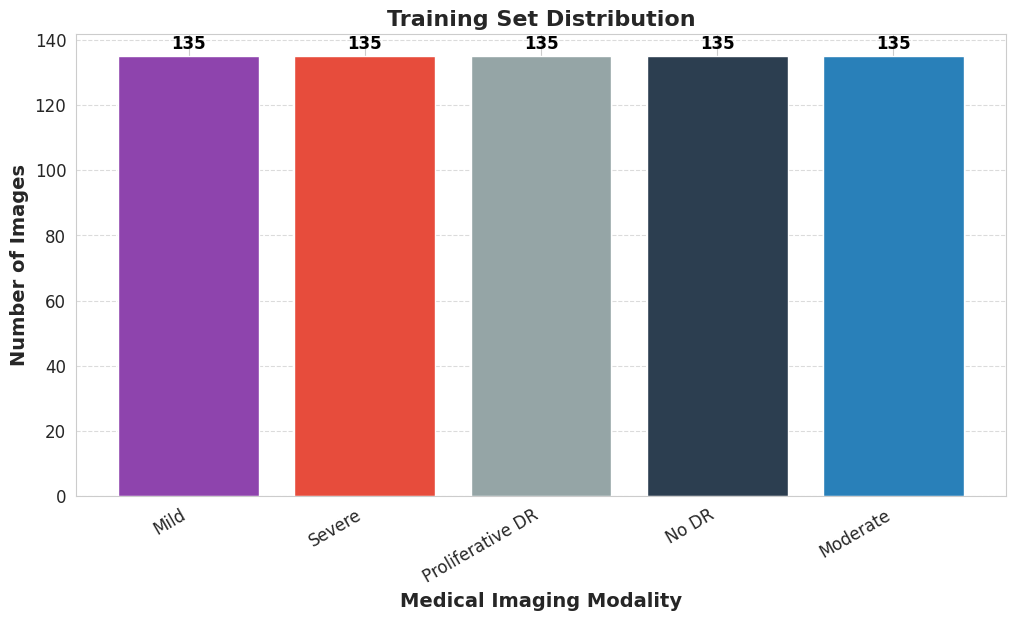

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the labels are numerical if they are in string format
label_mapping = {
    "No DR": 0,
    "Mild": 1,
    "Moderate": 2,
    "Severe": 3,
    "Proliferative DR": 4
}

# Convert string labels to integer-based labels
traindf_label_value_counts.index = traindf_label_value_counts.index.map(label_mapping)


# Define custom colors
colors = ["#E74C3C", "#2C3E50", "#2980B9", "#8E44AD", "#95A5A6", "#27AE60"]

# Apply Seaborn style
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(
    traindf_label_value_counts.index,
    traindf_label_value_counts.values,
    color=colors
)

# Annotate bars with counts
for bar in bars:
    height = bar.get_height()
    plt.annotate(f"{height}",
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),
                 textcoords="offset points",
                 ha="center",
                 fontsize=12,
                 fontweight="bold",
                 color="black")


# Now, use the updated index for plotting
plt.xticks(
    ticks=traindf_label_value_counts.index,
    labels=[classes_names[i] for i in traindf_label_value_counts.index],
    rotation=30,
    ha="right",
    fontsize=12
)
# Formatting
plt.xticks(ticks=traindf_label_value_counts.index, labels=[classes_names[i] for i in traindf_label_value_counts.index], rotation=30, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Medical Imaging Modality", fontsize=14, fontweight="bold")
plt.ylabel("Number of Images", fontsize=14, fontweight="bold")
plt.title("Training Set Distribution", fontsize=16, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


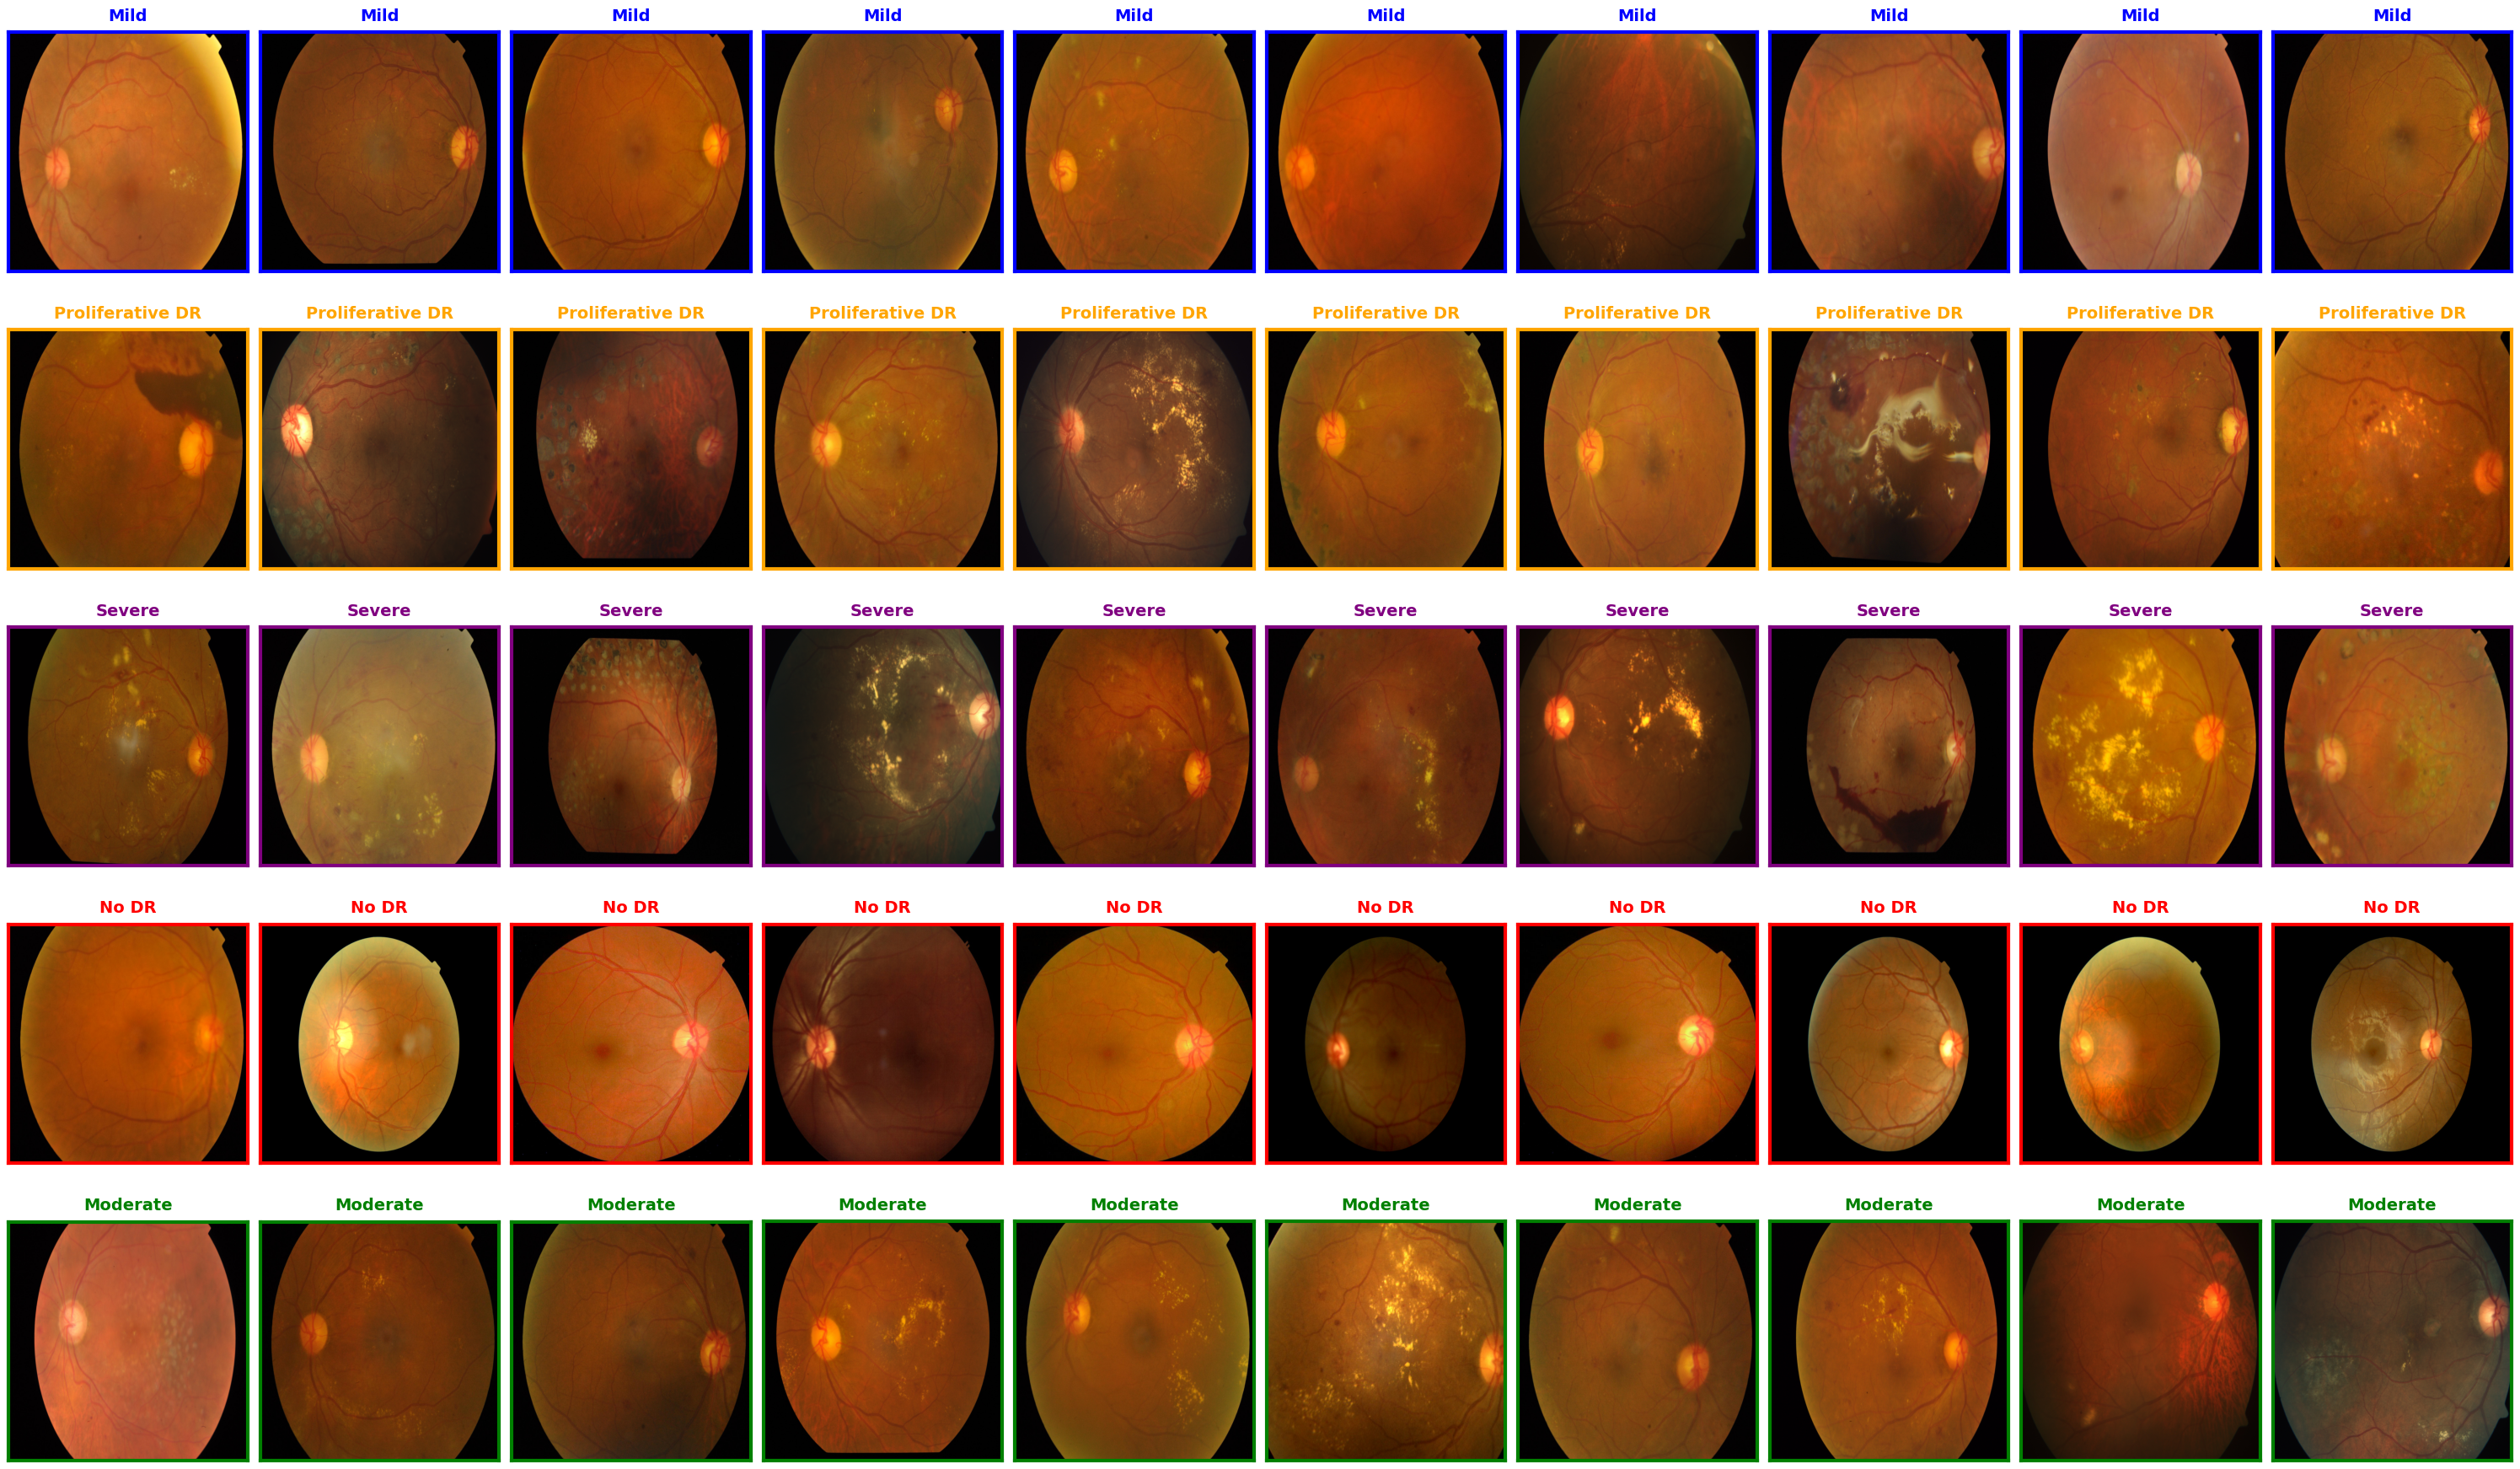

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Define class labels (as found in your dataset)
class_labels = ["Mild", "Proliferative DR", "Severe", "No DR", "Moderate"]

# Define a unique color per class for border styling
class_colors = {
    "Mild": "blue",
    "Proliferative DR": "orange",
    "Severe": "purple",
    "No DR": "red",
    "Moderate": "green"
}

# Collect file paths for each class
samples_per_class = 10
image_paths = {}

for class_name in class_labels:
    file_paths = train_df[train_df['label'] == class_name]['file_path'].values

    # If a class has fewer than 10 images, take all available images
    if len(file_paths) > 0:
        image_paths[class_name] = np.random.choice(file_paths, min(samples_per_class, len(file_paths)), replace=False)
    else:
        image_paths[class_name] = []  # Empty list if no images exist

# Set up subplot grid (5 rows for 5 classes, 10 columns)
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(30, 18))

# Function to display images with fancy borders
def display_image(ax, img_path, title, border_color):
    try:
        img = mpimg.imread(img_path)
        ax.imshow(img, cmap="gray")  # Display in grayscale
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title, fontsize=14, fontweight="bold", color=border_color, pad=10)

        # Add border effect by setting the edge color of the subplot
        for spine in ax.spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(3)

    except Exception as e:
        ax.axis("off")  # Hide empty images if there's an issue

# Populate subplots with images
for row, (class_name, img_list) in enumerate(image_paths.items()):
    for col in range(10):  # Ensure each row has 10 images
        if col < len(img_list):
            display_image(axes[row, col], img_list[col], class_name, class_colors[class_name])
        else:
            axes[row, col].axis("off")  # Hide empty subplots if fewer than 10 images

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Data Augmentation and Transformation

In [11]:
import os
import torch
import time
import numpy as np
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# ✅ Handle truncated images gracefully
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ===========================================================
# 🔥 **Optimized Data Augmentation for Medical Imaging**
# ===========================================================

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),  # Avoid excessive cropping
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),  # Small rotation for orientation-sensitive images
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Mild translation
    transforms.ColorJitter(brightness=0.1, contrast=0.2),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),  # Reduce noise, preserve details
    transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.5),
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize (handles grayscale images too)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# ===========================================================
# 🔥 **Custom Dataset with Enhanced Label Encoding & Error Handling**
# ===========================================================
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # 🔹 **Map Class Labels to Integers**
        self.label_mapping = {
            "No DR": 0,
            "Mild": 1,
            "Moderate": 2,
            "Severe": 3,
            "Proliferative DR": 4
        }

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        label_str = self.dataframe.iloc[idx]['label']

        # ✅ Ensure label exists in mapping
        label = self.label_mapping.get(label_str, -1)
        if label == -1:
            print(f"⚠ Warning: Unknown label {label_str} in file {img_path}")
            return None

        # ✅ Handle missing files gracefully
        if not os.path.isfile(img_path):
            print(f"⚠ Warning: Missing file {img_path}")
            return None

        try:
            img = Image.open(img_path).convert('RGB')  # Ensure 3-channel image
        except Exception as e:
            print(f"❌ Error loading image {img_path}: {e}")
            return None

        # ✅ Apply transformations
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

# ===========================================================
# 🔥 **Create Optimized Datasets**
# ===========================================================
train_dataset = CustomDataset(train_df, transform=train_transform)
valid_dataset = CustomDataset(val_df, transform=test_transform)
test_dataset  = CustomDataset(test_df, transform=test_transform)

# ===========================================================
# 🔥 **Optimized DataLoaders for High-Speed Training**
# ===========================================================
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=2, pin_memory=True)

# ===========================================================
# 🔥 **Test DataLoader Performance**
# ===========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

for i, batch in enumerate(train_loader):
    if batch is None:
        continue  # ✅ Skip None batches

    inputs, labels = batch
    start_time = time.time()

    # ✅ Transfer batch to GPU (or CPU)
    inputs, labels = inputs.to(device), labels.to(device)

    batch_time = time.time() - start_time
    print(f"✅ Batch {i+1} Loaded in {batch_time:.4f} sec")

    if i == 4:  # Stop after 5 batches
        break


Using device: cuda
✅ Batch 1 Loaded in 0.0039 sec
✅ Batch 2 Loaded in 0.0038 sec
✅ Batch 3 Loaded in 0.0036 sec
✅ Batch 4 Loaded in 0.0038 sec
✅ Batch 5 Loaded in 0.0037 sec


In [13]:

print(f'how many batch do we have in train loader? :{len(train_loader)}')
print(f'how many batch do we have in validation loader? :{len(val_loader)}')
print(f'how many batch do we have in test loader? :{len(test_loader)}')


how many batch do we have in train loader? :11
how many batch do we have in validation loader? :4
how many batch do we have in test loader? :2


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


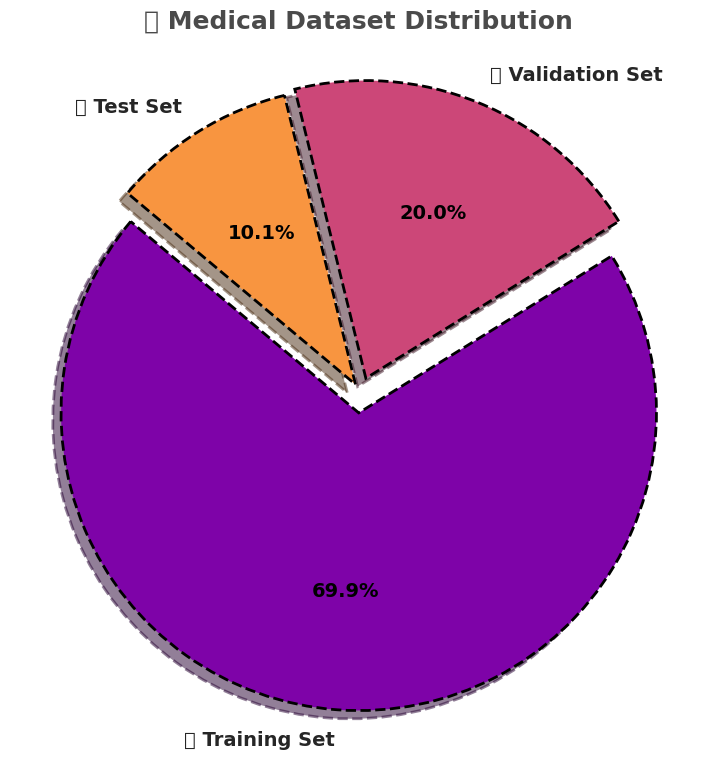

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create an attractive pie chart
def plot_pie_chart(sizes, labels, title):
    colors = sns.color_palette("plasma", len(sizes))  # Vibrant color theme 🌈
    explode = [0.07, 0.05, 0.03]  # Different explode values for emphasis 💥

    plt.figure(figsize=(9, 9))  # Slightly larger size for better visibility
    wedges, texts, autotexts = plt.pie(
        sizes, labels=labels, autopct='%1.1f%%', startangle=140,
        colors=colors, explode=explode, shadow=True,
        wedgeprops={'edgecolor': 'black', 'linewidth': 2, 'linestyle': '--'}
    )

    # Customize text appearance 🎨
    for text in texts:
        text.set_fontsize(14)
        text.set_fontweight('bold')

    for autotext in autotexts:
        autotext.set_fontsize(14)
        autotext.set_color('black')  # Increased contrast for better readability
        autotext.set_fontweight('bold')

    # Add a title with an emoji 📊
    plt.title(title, fontsize=18, fontweight='bold', color="#4A4A4A", pad=15)
    plt.axis('equal')  # Keep the pie circular
    plt.show()

# Get the dataset sizes
train_size = len(train_loader.dataset)
val_size = len(val_loader.dataset)
test_size = len(test_loader.dataset)

# Labels and sizes
sizes = [train_size, val_size, test_size]
labels = ['🟢 Training Set', '🔵 Validation Set', '🟠 Test Set']  # Emojis for fun!

# Plot the pie chart
plot_pie_chart(sizes, labels, '📊 Medical Dataset Distribution')


#Modeling

In [15]:

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    # Get the current device
    current_device = torch.cuda.current_device()
    print(f"Current CUDA device: {current_device}")

    # Get the number of GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # Get the name of the GPU
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")






CUDA is available!
Current CUDA device: 0
Number of available GPUs: 1
GPU 0: Tesla T4


## Resnext101_32x_8d

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler
from torchsummary import summary
import torchvision.models as models

# ===========================================================
# 🔥 **Fully Fine-Tuned ResNeXt-101 Model**
# ===========================================================
class ResNeXt101FineTuned(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNeXt101FineTuned, self).__init__()

        # Load pre-trained ResNeXt-101 model
        self.resnext101 = models.resnext101_32x8d(pretrained=True)

        # ✅ Unfreeze ALL layers for full fine-tuning
        for param in self.resnext101.parameters():
            param.requires_grad = True

        # ✅ Modify the final classification layer to fit num_classes
        in_features = self.resnext101.fc.in_features
        self.resnext101.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnext101(x)

# ===========================================================
# ✅ **Initialize Model & Move to GPU**
# ===========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNeXt101FineTuned(num_classes=5).to(device)

# ✅ Print Model Summary with 224x224 input size (since images are resized)
summary(model, (3, 224, 224))  # Adjusted input shape to 224x224 for resized images




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:06<00:00, 55.0MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]          16,384
       BatchNorm2d-6          [-1, 256, 56, 56]             512
              ReLU-7          [-1, 256, 56, 56]               0
            Conv2d-8          [-1, 256, 56, 56]          18,432
       BatchNorm2d-9          [-1, 256, 56, 56]             512
             ReLU-10          [-1, 256, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          65,536
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [17]:
# ✅ Define Hyperparameters
num_epochs = 50
lr = 1e-5  # Increased for better convergence
weight_decay = 2e-4  # Moderate regularization

# ✅ Loss Function: Use CrossEntropyLoss (for Multi-Class)
loss_fn = nn.CrossEntropyLoss()

# ✅ Optimizer: AdamW (Better Generalization)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# ✅ Learning Rate Scheduler: Cosine Annealing + ReduceLROnPlateau
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)  # Cosine decay

# ✅ Gradient Scaling for Mixed Precision Training (Speed & Stability)
scaler = GradScaler()

# ✅ Model Training Check
print(f"✅ Model Initialized on {device}")


✅ Model Initialized on cuda


<ipython-input-17-3c9f84335736>:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [18]:
import os

class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, monitor='loss'):
        """
        patience: How many epochs to wait before stopping.
        verbose: Whether to print progress.
        delta: Minimum change to qualify as an improvement.
        monitor: What to monitor ('loss' or 'accuracy').
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = float('inf') if monitor == 'loss' else -float('inf')  # Initialize based on monitor type
        self.best_epoch = 0
        self.early_stop = False
        self.delta = delta
        self.monitor = monitor  # What to monitor: 'loss' or 'accuracy'

    def __call__(self, val_score, epoch, model_weights, model_name_prefix):
        """
        val_score: The validation loss/accuracy in the current epoch.
        epoch: The current epoch.
        model_weights: The weights of the model (usually model.state_dict()).
        model_name_prefix: The prefix for the model's name (e.g., 'model_1', 'model_2').
        """
        # If monitoring 'loss', we expect the value to decrease
        if self.monitor == 'loss':
            if val_score < self.best_score - self.delta:
                self.best_score = val_score
                self.best_epoch = epoch
                self.counter = 0
                self.save_best_weights(model_weights, model_name_prefix)
            else:
                self.counter += 1
        # If monitoring 'accuracy', we expect the value to increase
        elif self.monitor == 'accuracy':
            if val_score > self.best_score + self.delta:
                self.best_score = val_score
                self.best_epoch = epoch
                self.counter = 0
                self.save_best_weights(model_weights, model_name_prefix)
            else:
                self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True
            if self.verbose:
                print(f"Early stopping triggered after {self.counter} epochs of no improvement.")

    def save_best_weights(self, model_weights, model_name_prefix):
        """
        Save the model weights with a unique name for each model.
        model_name_prefix: The prefix for the model's name (e.g., 'model_1', 'model_2').
        """
        model_name = f"{model_name_prefix}_epoch_{self.best_epoch + 1}.pth"

        # Clean up previous saved model files (optional, to avoid disk clutter)
        for file in os.listdir():
            if file.startswith(model_name_prefix) and file != model_name:
                os.remove(file)
                if self.verbose:
                    print(f"🗑️ Deleted old model file: {file}")

        torch.save(model_weights, model_name)
        if self.verbose:
            print(f"✅ Best model weights saved to {model_name}.")


In [52]:

# Training loop
best_val_loss = float('inf')  # Initialize best validation loss
best_model_weights = None

def train_and_validate(model, train_loader, valid_loader, optimizer, scheduler, criterion, model_name_prefix, epochs=25, device=None, early_stopping=None):

    # Store losses and accuracies
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    auc_scores = []

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 50)

        # Training phase
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Ensure labels are Long for CrossEntropyLoss
            labels = labels.long()  # Cast labels to Long

            # Mixed precision forward pass
            with torch.amp.autocast('cuda'):

                raw_outputs = model(inputs)  # Get raw logits (not passed through softmax)
                loss = criterion(raw_outputs, labels)  # Compute loss

            # Backward pass with mixed precision
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)

            # Compute predictions (Get class with highest logit)
            with torch.no_grad():
                _, preds = torch.max(raw_outputs, 1)  # Preds are class indices
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_preds.double() / total_preds
        print(f'Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # Store training loss and accuracy
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Ensure labels are Long for CrossEntropyLoss
                labels = labels.long()  # Cast labels to Long

                with torch.amp.autocast('cuda'):
                    raw_outputs = model(inputs)  # Get raw logits
                    loss = criterion(raw_outputs, labels)  # Compute loss

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(raw_outputs, 1)  # Preds are class indices
                correct_preds += torch.sum(preds == labels.data)
                total_preds += labels.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(valid_loader.dataset)
        epoch_acc = correct_preds.double() / total_preds
        print(f'Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # Store validation loss and accuracy
        valid_losses.append(epoch_loss)
        valid_accuracies.append(epoch_acc.item())


        # Step the scheduler based on validation loss
        scheduler.step(epoch_loss)

        # ✅ Early stopping check: save model based on validation loss
        if early_stopping is not None:
            early_stopping(epoch_loss, epoch, model.state_dict(), model_name_prefix="model")
            if early_stopping.early_stop:
                print(f"🚨 Early stopping triggered at epoch {epoch+1}.")
                break

        # ✅ Display confusion matrix & classification report every 5 epochs
        if epoch % 5 == 0 or early_stopping.early_stop:
            cm = confusion_matrix(all_labels, all_preds)
            plot_confusion_matrix(cm, classes=[i for i in range(len(set(all_labels)))])
            print("Classification Report:")
            print(classification_report(all_labels, all_preds))

    # ✅ Load the best model weights from early stopping
    print("Loading best model weights...")
    model.load_state_dict(torch.load("model_epoch_{}.pth".format(early_stopping.best_epoch + 1)))

    # ✅ Plot training metrics
    plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies)


    return model





# Helper function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


# Helper function to plot losses, accuracies, and AUC scores
def plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(16, 8))

    # Plot training and validation loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, valid_losses, label='Validation Loss', color='red')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy', color='red')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()



    plt.tight_layout()
    plt.show()


In [54]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def test_model(model, test_loader, criterion, device, num_classes=6):
    """
    Evaluates the model on the test set, computes loss and accuracy,
    and displays the confusion matrix and classification report.

    Args:
        model: The trained PyTorch model.
        test_loader: DataLoader for the test set.
        criterion: The loss function used during training (e.g., CrossEntropyLoss).
        device: The device to run inference on (e.g., torch.device('cuda') or torch.device('cpu')).
        num_classes: The number of classes in the classification task.
    """
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Use autocast for mixed precision inference
            with torch.amp.autocast('cuda'):
                raw_outputs = model(inputs)  # Get raw logits from the model
                loss = criterion(raw_outputs, labels)  # Compute loss

            running_loss += loss.item() * inputs.size(0)

            # Get class predictions (highest probability for multi-class)
            _, preds = torch.max(raw_outputs, 1)

            # Update accuracy counters
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            # Accumulate for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate overall test loss and accuracy
    test_loss = running_loss / len(test_loader.dataset)
    test_accuracy = correct_preds.double() / total_preds

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Compute confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(num_classes)]))

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Epoch 1/20
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 1.5006, Accuracy: 0.3422


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 1.4115, Accuracy: 0.4456


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


✅ Best model weights saved to model_epoch_1.pth.


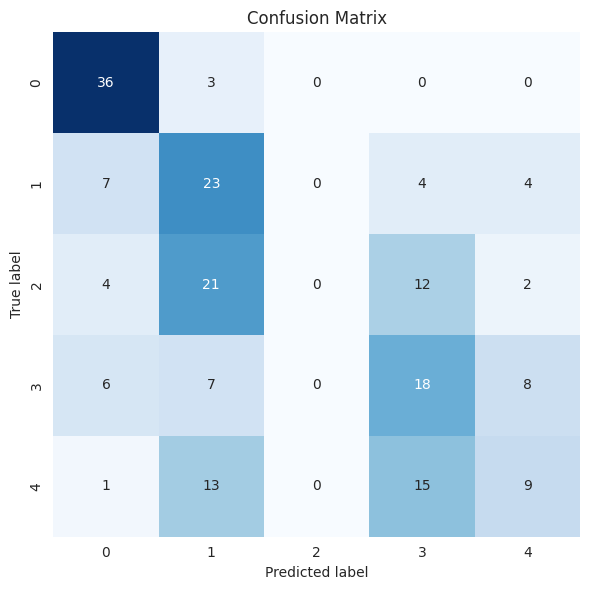

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.92      0.77        39
           1       0.34      0.61      0.44        38
           2       0.00      0.00      0.00        39
           3       0.37      0.46      0.41        39
           4       0.39      0.24      0.30        38

    accuracy                           0.45       193
   macro avg       0.35      0.45      0.38       193
weighted avg       0.35      0.45      0.38       193

Epoch 2/20
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-19-cfa2548f3618>:32: FutureWarning

Training Loss: 1.2361, Accuracy: 0.5259


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 1.2267, Accuracy: 0.4922
🗑️ Deleted old model file: model_epoch_1.pth


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


✅ Best model weights saved to model_epoch_2.pth.
Epoch 3/20
--------------------------------------------------
Training Loss: 1.0648, Accuracy: 0.6059
Validation Loss: 1.1161, Accuracy: 0.5389
🗑️ Deleted old model file: model_epoch_2.pth
✅ Best model weights saved to model_epoch_3.pth.
Epoch 4/20
--------------------------------------------------
Training Loss: 0.9716, Accuracy: 0.6504
Validation Loss: 1.0510, Accuracy: 0.5544
🗑️ Deleted old model file: model_epoch_3.pth
✅ Best model weights saved to model_epoch_4.pth.
Epoch 5/20
--------------------------------------------------
Training Loss: 0.8793, Accuracy: 0.6667
Validation Loss: 0.9969, Accuracy: 0.6166
🗑️ Deleted old model file: model_epoch_4.pth
✅ Best model weights saved to model_epoch_5.pth.
Epoch 6/20
--------------------------------------------------
Training Loss: 0.8173, Accuracy: 0.7067
Validation Loss: 0.9639, Accuracy: 0.6269
🗑️ Deleted old model file: model_epoch_5.pth
✅ Best model weights saved to model_epoch_6.pth.

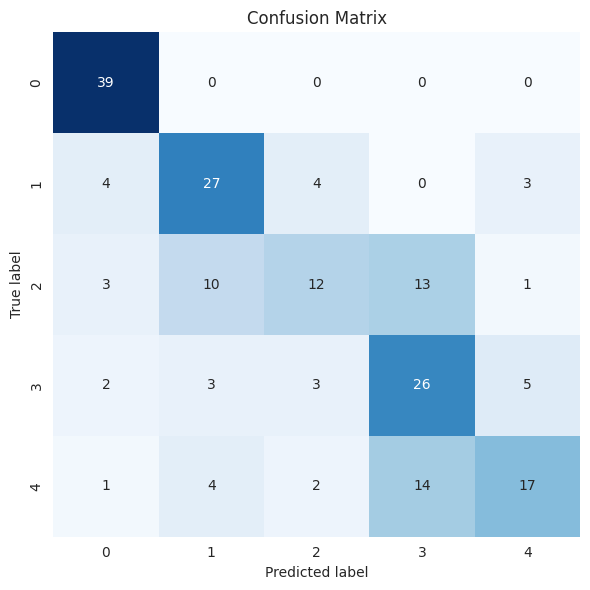

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        39
           1       0.61      0.71      0.66        38
           2       0.57      0.31      0.40        39
           3       0.49      0.67      0.57        39
           4       0.65      0.45      0.53        38

    accuracy                           0.63       193
   macro avg       0.63      0.63      0.61       193
weighted avg       0.62      0.63      0.61       193

Epoch 7/20
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.7602, Accuracy: 0.7244


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 0.9422, Accuracy: 0.6373
🗑️ Deleted old model file: model_epoch_6.pth


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


✅ Best model weights saved to model_epoch_7.pth.
Epoch 8/20
--------------------------------------------------
Training Loss: 0.6775, Accuracy: 0.7511
Validation Loss: 0.9274, Accuracy: 0.6269
🗑️ Deleted old model file: model_epoch_7.pth
✅ Best model weights saved to model_epoch_8.pth.
Epoch 9/20
--------------------------------------------------
Training Loss: 0.6263, Accuracy: 0.7807
Validation Loss: 0.9046, Accuracy: 0.6218
🗑️ Deleted old model file: model_epoch_8.pth
✅ Best model weights saved to model_epoch_9.pth.
Epoch 10/20
--------------------------------------------------
Training Loss: 0.5642, Accuracy: 0.8044
Validation Loss: 0.8900, Accuracy: 0.6269
🗑️ Deleted old model file: model_epoch_9.pth
✅ Best model weights saved to model_epoch_10.pth.
Epoch 11/20
--------------------------------------------------
Training Loss: 0.5103, Accuracy: 0.8296
Validation Loss: 0.9027, Accuracy: 0.6580


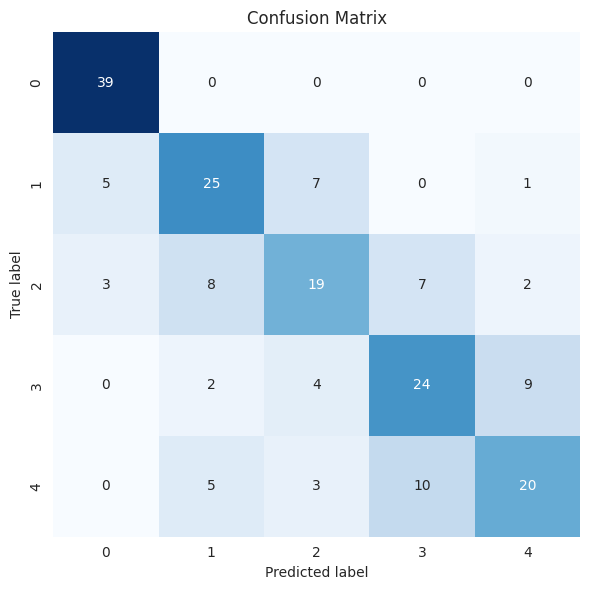

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        39
           1       0.62      0.66      0.64        38
           2       0.58      0.49      0.53        39
           3       0.59      0.62      0.60        39
           4       0.62      0.53      0.57        38

    accuracy                           0.66       193
   macro avg       0.65      0.66      0.65       193
weighted avg       0.65      0.66      0.65       193

Epoch 12/20
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.4648, Accuracy: 0.8563


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 0.9046, Accuracy: 0.6580
Epoch 13/20
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training Loss: 0.4329, Accuracy: 0.8385
Validation Loss: 0.9230, Accuracy: 0.6528
Epoch 14/20
--------------------------------------------------
Training Loss: 0.3759, Accuracy: 0.8889
Validation Loss: 0.9115, Accuracy: 0.6580
Epoch 15/20
--------------------------------------------------
Training Loss: 0.3316, Accuracy: 0.9037
Validation Loss: 0.9196, Accuracy: 0.6477
Early stopping triggered after 5 epochs of no improvement.
🚨 Early stopping triggered at epoch 15.
Loading best model weights...


<ipython-input-19-cfa2548f3618>:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_epoch_{}.pth".format(early_stopping.best_epoch + 1

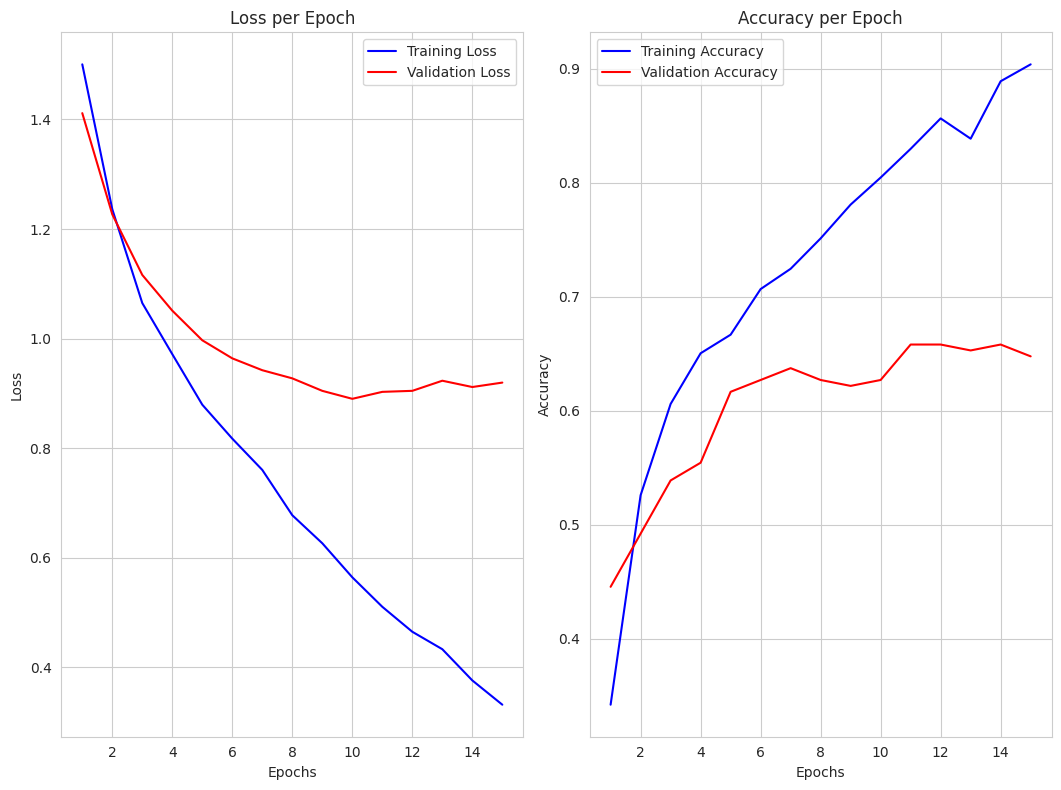

In [21]:
# Example:
early_stopping = EarlyStopping(patience=5, verbose=True, delta=0)
model_name_prefix = "model_resnext101"  # Or dynamically change this per model
trained_model = train_and_validate(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    loss_fn,
    epochs=20,
    device=device,
    early_stopping=early_stopping,
    model_name_prefix=model_name_prefix)



<ipython-input-20-e6c803e16848>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Test Loss: 1.0123, Test Accuracy: 0.6082
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        19
           1       0.64      0.35      0.45        20
           2       0.38      0.58      0.46        19
           3       0.59      0.68      0.63        19
           4       0.67      0.50      0.57        20

    accuracy                           0.61        97
   macro avg       0.63      0.61      0.61        97
weighted avg       0.63      0.61      0.61        97



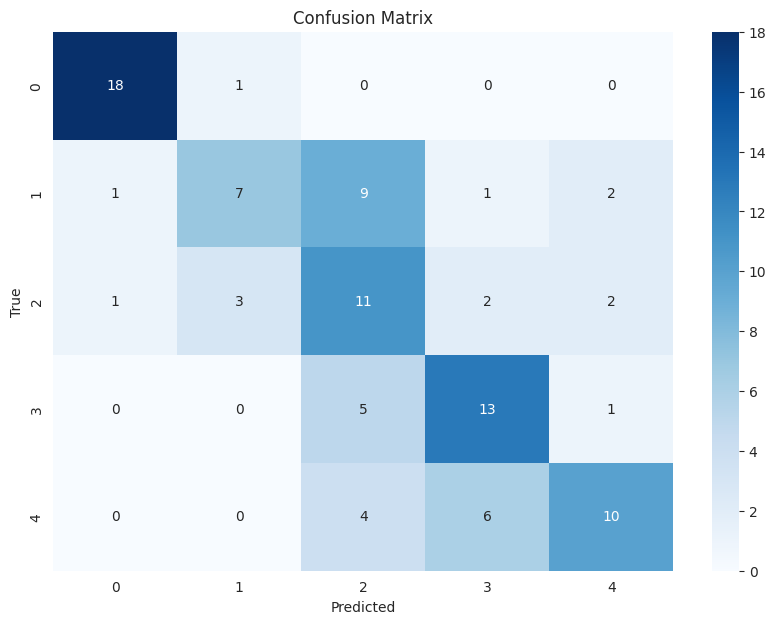

In [22]:
test_model(model, test_loader, loss_fn, device, num_classes=5)

## Resnext50

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary

# ===========================================================
# 🔥 **Fully Fine-Tuned ResNeXt Model**
# ===========================================================
class ResNeXtFineTuned(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNeXtFineTuned, self).__init__()
        self.resnext = models.resnext50_32x4d(pretrained=True)

        # ✅ Unfreeze ALL layers for full fine-tuning
        for param in self.resnext.parameters():
            param.requires_grad = True

        # ✅ Modify the final classification layer
        in_features = self.resnext.fc.in_features
        self.resnext.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnext(x)

# ===========================================================
# ✅ **Initialize Model & Move to GPU**
# ===========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNeXtFineTuned(num_classes=5).to(device)

# ✅ Print Model Summary with 224x224 input size (since images are resized)
summary(model, (3, 224, 224))  # Adjusted input shape to 224x224 for resized images


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 122MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [26]:
# ✅ Define Hyperparameters
num_epochs = 50
lr = 1e-5  # Increased for better convergence
weight_decay = 2e-4  # Moderate regularization

# ✅ Loss Function: Use CrossEntropyLoss (for Multi-Class)
loss_fn = nn.CrossEntropyLoss()

# ✅ Optimizer: AdamW (Better Generalization)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)


# ✅ Learning Rate Scheduler: ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',  # Reduce the learning rate when the validation loss stops decreasing
    factor=0.5,  # Reduce learning rate by 50%
    patience=3,  # Number of epochs with no improvement before reducing lr
    verbose=True  # Display when the learning rate is reduced
    #min_lr=1e-7  # Minimum learning rate (avoid going below this value)
)
# ✅ Gradient Scaling for Mixed Precision Training (Speed & Stability)
scaler = GradScaler()

# ✅ Model Training Check
print(f"✅ Model Initialized on {device}")


✅ Model Initialized on cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-26-1e2e8e8c2b86>:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/25
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 1.5830, Accuracy: 0.2356


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 1.5308, Accuracy: 0.3109
🗑️ Deleted old model file: model_epoch_10.pth
✅ Best model weights saved to model_epoch_1.pth.


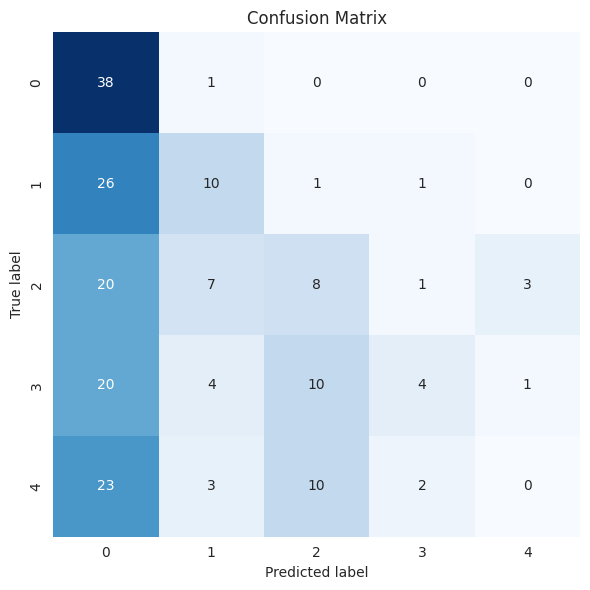

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.97      0.46        39
           1       0.40      0.26      0.32        38
           2       0.28      0.21      0.24        39
           3       0.50      0.10      0.17        39
           4       0.00      0.00      0.00        38

    accuracy                           0.31       193
   macro avg       0.30      0.31      0.24       193
weighted avg       0.30      0.31      0.24       193

Epoch 2/25
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 1.4289, Accuracy: 0.4104


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 1.3974, Accuracy: 0.4093
🗑️ Deleted old model file: model_epoch_1.pth
✅ Best model weights saved to model_epoch_2.pth.
Epoch 3/25
--------------------------------------------------
Training Loss: 1.3196, Accuracy: 0.5244
Validation Loss: 1.2976, Accuracy: 0.4404
🗑️ Deleted old model file: model_epoch_2.pth
✅ Best model weights saved to model_epoch_3.pth.
Epoch 4/25
--------------------------------------------------
Training Loss: 1.2172, Accuracy: 0.5689
Validation Loss: 1.2301, Accuracy: 0.4715
🗑️ Deleted old model file: model_epoch_3.pth
✅ Best model weights saved to model_epoch_4.pth.
Epoch 5/25
--------------------------------------------------
Training Loss: 1.1358, Accuracy: 0.5985
Validation Loss: 1.1746, Accuracy: 0.5337
🗑️ Deleted old model file: model_epoch_4.pth
✅ Best model weights saved to model_epoch_5.pth.
Epoch 6/25
--------------------------------------------------
Training Loss: 1.0653, Accuracy: 0.6281
Validation Loss: 1.1133, Accuracy: 0.5648
🗑️ Del

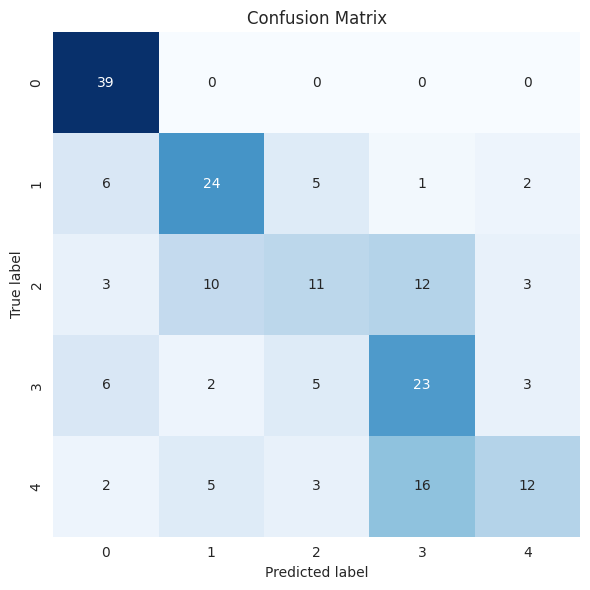

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82        39
           1       0.59      0.63      0.61        38
           2       0.46      0.28      0.35        39
           3       0.44      0.59      0.51        39
           4       0.60      0.32      0.41        38

    accuracy                           0.56       193
   macro avg       0.56      0.56      0.54       193
weighted avg       0.56      0.56      0.54       193

Epoch 7/25
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 1.0138, Accuracy: 0.6444


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 1.0756, Accuracy: 0.5751
🗑️ Deleted old model file: model_epoch_6.pth
✅ Best model weights saved to model_epoch_7.pth.
Epoch 8/25
--------------------------------------------------
Training Loss: 0.9504, Accuracy: 0.6711
Validation Loss: 1.0396, Accuracy: 0.6010
🗑️ Deleted old model file: model_epoch_7.pth
✅ Best model weights saved to model_epoch_8.pth.
Epoch 9/25
--------------------------------------------------
Training Loss: 0.9256, Accuracy: 0.6652
Validation Loss: 1.0149, Accuracy: 0.6010
🗑️ Deleted old model file: model_epoch_8.pth
✅ Best model weights saved to model_epoch_9.pth.
Epoch 10/25
--------------------------------------------------
Training Loss: 0.8670, Accuracy: 0.6800
Validation Loss: 0.9953, Accuracy: 0.5907
🗑️ Deleted old model file: model_epoch_9.pth
✅ Best model weights saved to model_epoch_10.pth.
Epoch 11/25
--------------------------------------------------
Training Loss: 0.8462, Accuracy: 0.6978
Validation Loss: 0.9823, Accuracy: 0.5907
🗑️ 

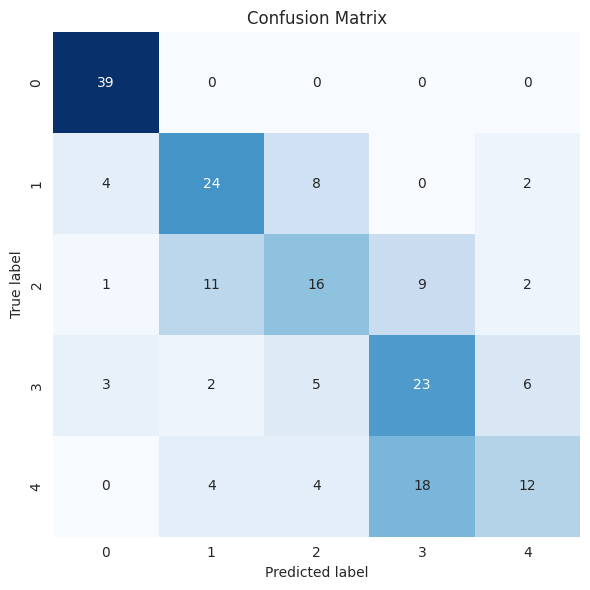

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        39
           1       0.59      0.63      0.61        38
           2       0.48      0.41      0.44        39
           3       0.46      0.59      0.52        39
           4       0.55      0.32      0.40        38

    accuracy                           0.59       193
   macro avg       0.58      0.59      0.58       193
weighted avg       0.58      0.59      0.58       193

Epoch 12/25
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.8038, Accuracy: 0.7007


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 0.9753, Accuracy: 0.5855
🗑️ Deleted old model file: model_epoch_11.pth
✅ Best model weights saved to model_epoch_12.pth.
Epoch 13/25
--------------------------------------------------
Training Loss: 0.7701, Accuracy: 0.7230
Validation Loss: 0.9617, Accuracy: 0.5959
🗑️ Deleted old model file: model_epoch_12.pth
✅ Best model weights saved to model_epoch_13.pth.
Epoch 14/25
--------------------------------------------------
Training Loss: 0.7251, Accuracy: 0.7348
Validation Loss: 0.9557, Accuracy: 0.5855
🗑️ Deleted old model file: model_epoch_13.pth
✅ Best model weights saved to model_epoch_14.pth.
Epoch 15/25
--------------------------------------------------
Training Loss: 0.7137, Accuracy: 0.7407
Validation Loss: 0.9534, Accuracy: 0.5907
🗑️ Deleted old model file: model_epoch_14.pth
✅ Best model weights saved to model_epoch_15.pth.
Epoch 16/25
--------------------------------------------------
Training Loss: 0.6589, Accuracy: 0.7704
Validation Loss: 0.9564, Accuracy: 0

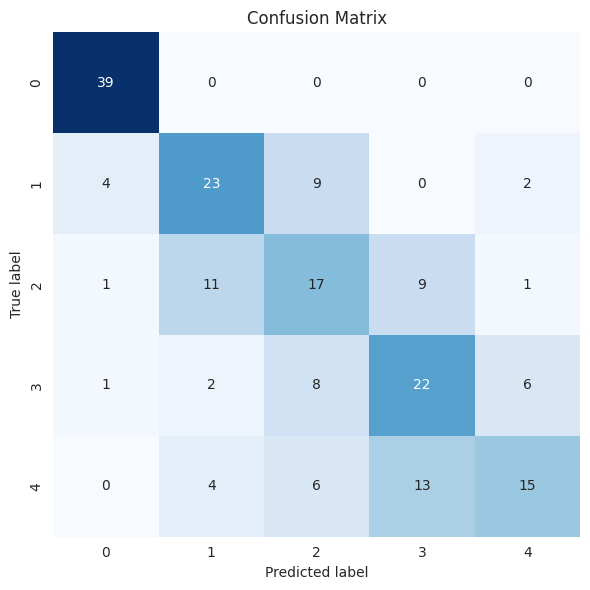

Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        39
           1       0.57      0.61      0.59        38
           2       0.42      0.44      0.43        39
           3       0.50      0.56      0.53        39
           4       0.62      0.39      0.48        38

    accuracy                           0.60       193
   macro avg       0.60      0.60      0.59       193
weighted avg       0.60      0.60      0.59       193

Epoch 17/25
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.6292, Accuracy: 0.7719


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 0.9510, Accuracy: 0.6010
🗑️ Deleted old model file: model_epoch_15.pth
✅ Best model weights saved to model_epoch_17.pth.
Epoch 18/25
--------------------------------------------------
Training Loss: 0.6212, Accuracy: 0.7674
Validation Loss: 0.9527, Accuracy: 0.6114
Epoch 19/25
--------------------------------------------------
Training Loss: 0.5668, Accuracy: 0.7970
Validation Loss: 0.9559, Accuracy: 0.6010
Epoch 20/25
--------------------------------------------------
Training Loss: 0.5451, Accuracy: 0.8044
Validation Loss: 0.9582, Accuracy: 0.6010
Epoch 21/25
--------------------------------------------------
Training Loss: 0.5237, Accuracy: 0.8119
Validation Loss: 0.9663, Accuracy: 0.6062


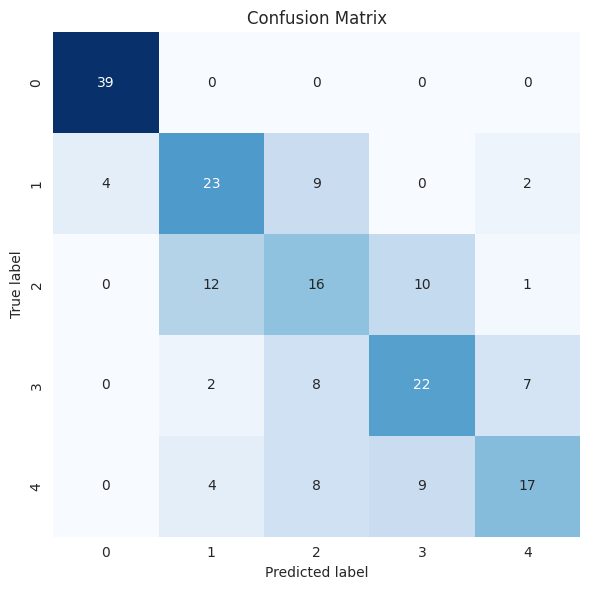

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        39
           1       0.56      0.61      0.58        38
           2       0.39      0.41      0.40        39
           3       0.54      0.56      0.55        39
           4       0.63      0.45      0.52        38

    accuracy                           0.61       193
   macro avg       0.60      0.61      0.60       193
weighted avg       0.60      0.61      0.60       193

Epoch 22/25
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.5048, Accuracy: 0.8281


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 0.9697, Accuracy: 0.6010
Epoch 23/25
--------------------------------------------------
Training Loss: 0.4830, Accuracy: 0.8489
Validation Loss: 0.9745, Accuracy: 0.6010
Epoch 24/25
--------------------------------------------------
Training Loss: 0.4754, Accuracy: 0.8489
Validation Loss: 0.9818, Accuracy: 0.6010
Early stopping triggered after 7 epochs of no improvement.
🚨 Early stopping triggered at epoch 24.
Loading best model weights...


<ipython-input-19-cfa2548f3618>:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_epoch_{}.pth".format(early_stopping.best_epoch + 1

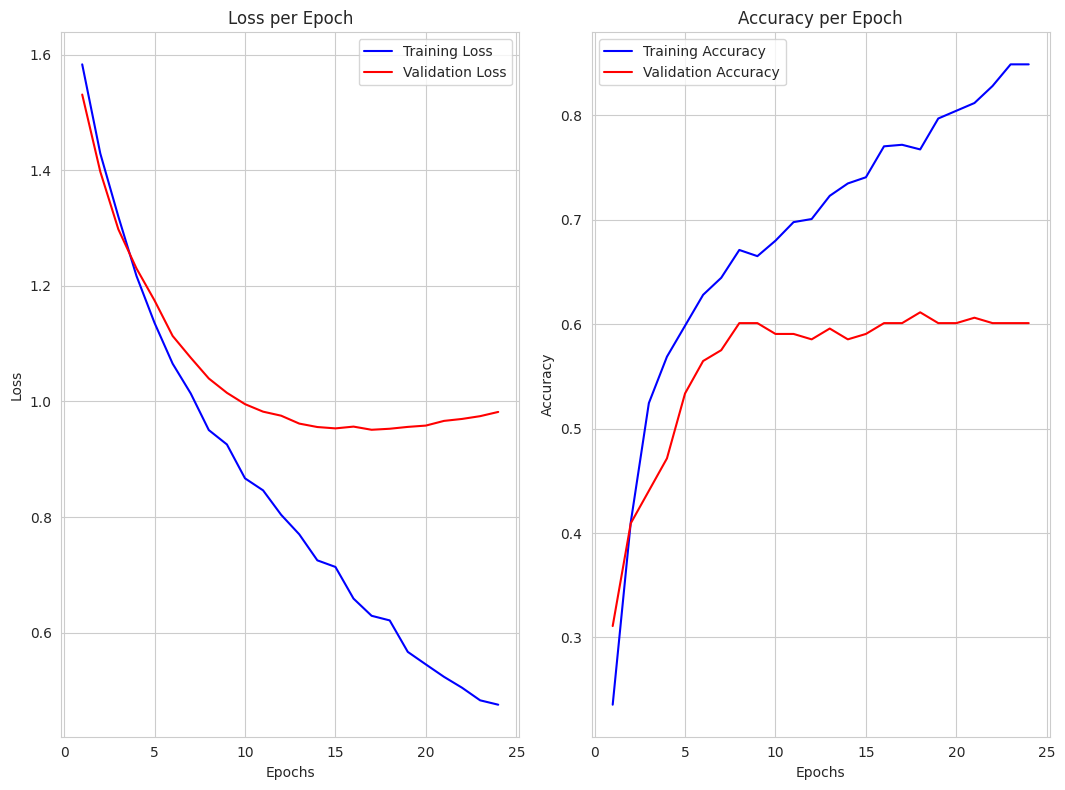

In [27]:
# Example:
early_stopping = EarlyStopping(patience=7, verbose=True, delta=0)
model_name_prefix = "model_resnext50_32_4d"  # Or dynamically change this per model
trained_model = train_and_validate(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    loss_fn,
    epochs=25,
    device=device,
    early_stopping=early_stopping,
    model_name_prefix=model_name_prefix)



<ipython-input-20-e6c803e16848>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Test Loss: 1.0536, Test Accuracy: 0.5670
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.95      0.86        19
           1       0.57      0.40      0.47        20
           2       0.42      0.58      0.49        19
           3       0.45      0.47      0.46        19
           4       0.64      0.45      0.53        20

    accuracy                           0.57        97
   macro avg       0.57      0.57      0.56        97
weighted avg       0.57      0.57      0.56        97



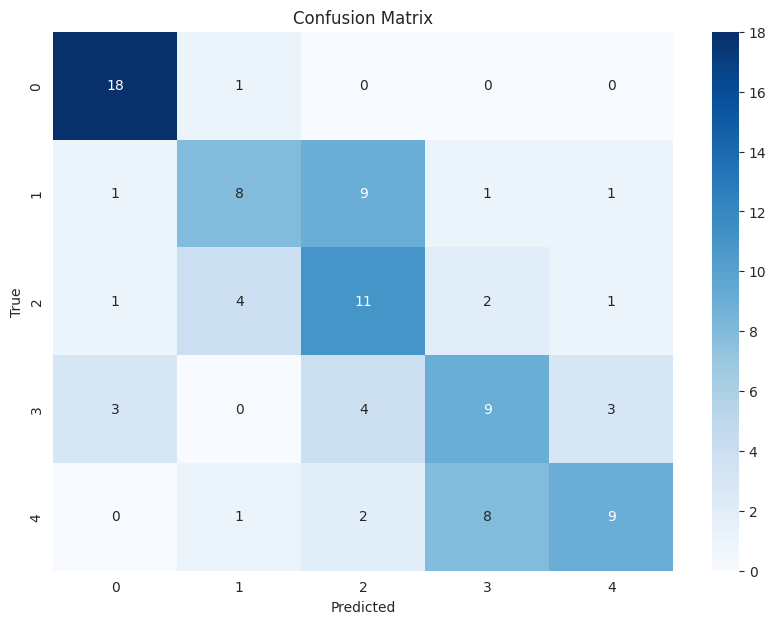

In [28]:
test_model(model, test_loader, loss_fn, device, num_classes=5)

## Resnet-18 model

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast
from torchsummary import summary
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ===========================================================
# 🔥 **Fully Fine-Tuned ResNet-18 Model**
# ===========================================================
class ResNet18FineTuned(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet18FineTuned, self).__init__()

        # Load pre-trained ResNet-18 model
        self.resnet18 = models.resnet18(pretrained=True)

        # ✅ Unfreeze ALL layers for full fine-tuning
        for param in self.resnet18.parameters():
            param.requires_grad = True

        # ✅ Modify the final classification layer to fit num_classes
        in_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet18(x)

# ===============================

In [41]:

# ✅ **Initialize Model & Move to GPU**
# ===========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18FineTuned(num_classes=5).to(device)

# ✅ Print Model Summary with 224x224 input size (since images are resized)
summary(model, (3, 224, 224))  # Adjusted input shape to 224x224 for resized images

# ✅ Model Training Check
print(f"✅ Model Initialized on {device}")

# ===========================================================
# Training loop
best_val_loss = float('inf')  # Initialize best validation loss
best_model_weights = None


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [43]:
# ✅ Define Hyperparameters
num_epochs = 50
lr = 1e-5  # Increased for better convergence
weight_decay = 2e-4  # Moderate regularization

# ✅ Loss Function: Use CrossEntropyLoss (for Multi-Class)
loss_fn = nn.CrossEntropyLoss()

# ✅ Optimizer: AdamW (Better Generalization)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)


# ✅ Learning Rate Scheduler: ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',  # Reduce the learning rate when the validation loss stops decreasing
    factor=0.5,  # Reduce learning rate by 50%
    patience=3,  # Number of epochs with no improvement before reducing lr
    verbose=True  # Display when the learning rate is reduced
    #min_lr=1e-7  # Minimum learning rate (avoid going below this value)
)
# ✅ Gradient Scaling for Mixed Precision Training (Speed & Stability)
scaler = GradScaler()

# ✅ Model Training Check
print(f"✅ Model Initialized on {device}")


✅ Model Initialized on cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-43-1e2e8e8c2b86>:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 1.7194, Accuracy: 0.2148


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 1.7941, Accuracy: 0.2021
🗑️ Deleted old model file: model_epoch_17.pth
✅ Best model weights saved to model_epoch_1.pth.


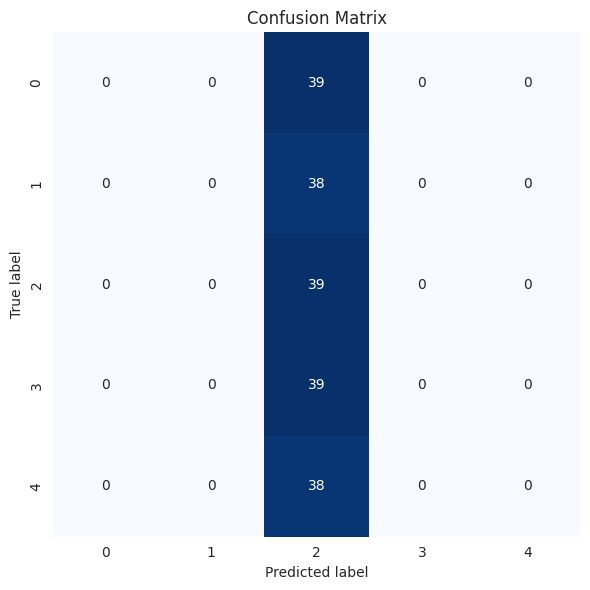

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.00      0.00      0.00        38
           2       0.20      1.00      0.34        39
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00        38

    accuracy                           0.20       193
   macro avg       0.04      0.20      0.07       193
weighted avg       0.04      0.20      0.07       193

Epoch 2/50
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-19-cfa2548f3618>:32: FutureWarning

Training Loss: 1.5657, Accuracy: 0.2859


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 1.5849, Accuracy: 0.3109
🗑️ Deleted old model file: model_epoch_1.pth
✅ Best model weights saved to model_epoch_2.pth.
Epoch 3/50
--------------------------------------------------
Training Loss: 1.4540, Accuracy: 0.3778
Validation Loss: 1.4475, Accuracy: 0.3731
🗑️ Deleted old model file: model_epoch_2.pth
✅ Best model weights saved to model_epoch_3.pth.
Epoch 4/50
--------------------------------------------------
Training Loss: 1.3462, Accuracy: 0.4059
Validation Loss: 1.3703, Accuracy: 0.3886
🗑️ Deleted old model file: model_epoch_3.pth
✅ Best model weights saved to model_epoch_4.pth.
Epoch 5/50
--------------------------------------------------
Training Loss: 1.2809, Accuracy: 0.4667
Validation Loss: 1.3299, Accuracy: 0.3990
🗑️ Deleted old model file: model_epoch_4.pth
✅ Best model weights saved to model_epoch_5.pth.
Epoch 6/50
--------------------------------------------------
Training Loss: 1.2206, Accuracy: 0.4726
Validation Loss: 1.2890, Accuracy: 0.4611
🗑️ Del

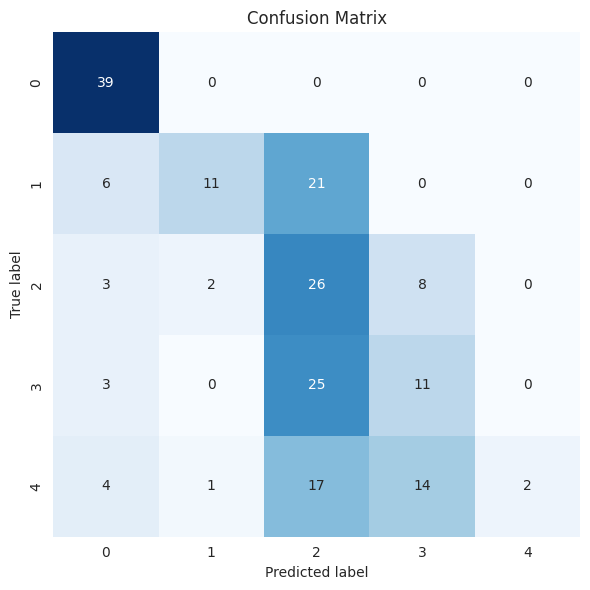

Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        39
           1       0.79      0.29      0.42        38
           2       0.29      0.67      0.41        39
           3       0.33      0.28      0.31        39
           4       1.00      0.05      0.10        38

    accuracy                           0.46       193
   macro avg       0.62      0.46      0.41       193
weighted avg       0.62      0.46      0.41       193

Epoch 7/50
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 1.1620, Accuracy: 0.5156


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 1.2447, Accuracy: 0.4870
🗑️ Deleted old model file: model_epoch_6.pth
✅ Best model weights saved to model_epoch_7.pth.
Epoch 8/50
--------------------------------------------------
Training Loss: 1.1075, Accuracy: 0.5496
Validation Loss: 1.2204, Accuracy: 0.4922
🗑️ Deleted old model file: model_epoch_7.pth
✅ Best model weights saved to model_epoch_8.pth.
Epoch 9/50
--------------------------------------------------
Training Loss: 1.0750, Accuracy: 0.5644
Validation Loss: 1.2029, Accuracy: 0.5026
🗑️ Deleted old model file: model_epoch_8.pth
✅ Best model weights saved to model_epoch_9.pth.
Epoch 10/50
--------------------------------------------------
Training Loss: 1.0462, Accuracy: 0.5719
Validation Loss: 1.1803, Accuracy: 0.5233
🗑️ Deleted old model file: model_epoch_9.pth
✅ Best model weights saved to model_epoch_10.pth.
Epoch 11/50
--------------------------------------------------
Training Loss: 0.9952, Accuracy: 0.5985
Validation Loss: 1.1640, Accuracy: 0.5130
🗑️ 

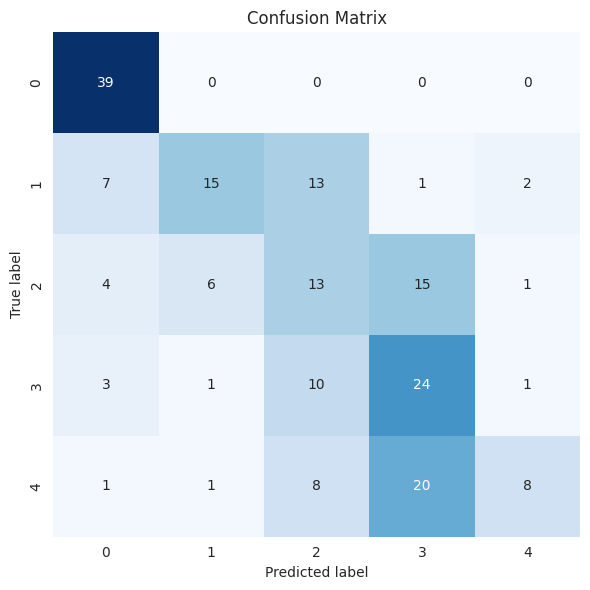

Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        39
           1       0.65      0.39      0.49        38
           2       0.30      0.33      0.31        39
           3       0.40      0.62      0.48        39
           4       0.67      0.21      0.32        38

    accuracy                           0.51       193
   macro avg       0.55      0.51      0.49       193
weighted avg       0.55      0.51      0.49       193

Epoch 12/50
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.9913, Accuracy: 0.6074


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 1.1476, Accuracy: 0.5233
🗑️ Deleted old model file: model_epoch_11.pth
✅ Best model weights saved to model_epoch_12.pth.
Epoch 13/50
--------------------------------------------------
Training Loss: 0.9364, Accuracy: 0.6474
Validation Loss: 1.1395, Accuracy: 0.5389
🗑️ Deleted old model file: model_epoch_12.pth
✅ Best model weights saved to model_epoch_13.pth.
Epoch 14/50
--------------------------------------------------
Training Loss: 0.9453, Accuracy: 0.6237
Validation Loss: 1.1201, Accuracy: 0.5492
🗑️ Deleted old model file: model_epoch_13.pth
✅ Best model weights saved to model_epoch_14.pth.
Epoch 15/50
--------------------------------------------------
Training Loss: 0.9180, Accuracy: 0.6326
Validation Loss: 1.1010, Accuracy: 0.5389
🗑️ Deleted old model file: model_epoch_14.pth
✅ Best model weights saved to model_epoch_15.pth.
Epoch 16/50
--------------------------------------------------
Training Loss: 0.9063, Accuracy: 0.6370
Validation Loss: 1.0905, Accuracy: 0

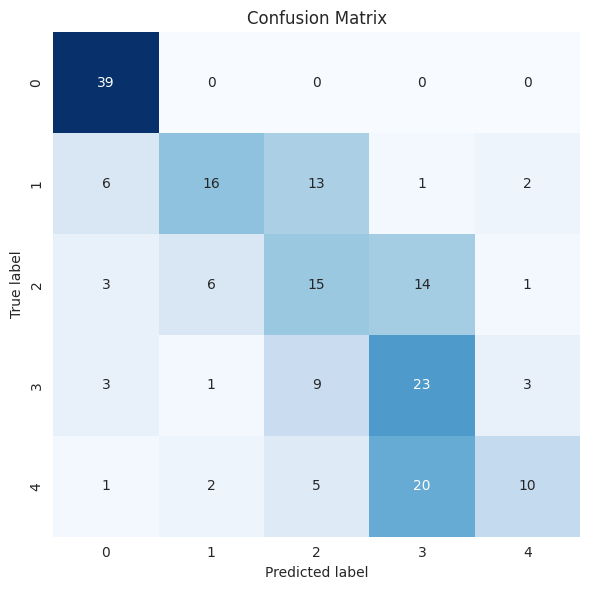

Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        39
           1       0.64      0.42      0.51        38
           2       0.36      0.38      0.37        39
           3       0.40      0.59      0.47        39
           4       0.62      0.26      0.37        38

    accuracy                           0.53       193
   macro avg       0.55      0.53      0.52       193
weighted avg       0.55      0.53      0.52       193

Epoch 17/50
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.8755, Accuracy: 0.6681


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 1.0815, Accuracy: 0.5440
🗑️ Deleted old model file: model_epoch_16.pth
✅ Best model weights saved to model_epoch_17.pth.
Epoch 18/50
--------------------------------------------------
Training Loss: 0.8657, Accuracy: 0.6652
Validation Loss: 1.0737, Accuracy: 0.5285
🗑️ Deleted old model file: model_epoch_17.pth
✅ Best model weights saved to model_epoch_18.pth.
Epoch 19/50
--------------------------------------------------
Training Loss: 0.8483, Accuracy: 0.6444
Validation Loss: 1.0665, Accuracy: 0.5544
🗑️ Deleted old model file: model_epoch_18.pth
✅ Best model weights saved to model_epoch_19.pth.
Epoch 20/50
--------------------------------------------------
Training Loss: 0.8408, Accuracy: 0.6667
Validation Loss: 1.0631, Accuracy: 0.5544
🗑️ Deleted old model file: model_epoch_19.pth
✅ Best model weights saved to model_epoch_20.pth.
Epoch 21/50
--------------------------------------------------
Training Loss: 0.8144, Accuracy: 0.6859
Validation Loss: 1.0505, Accuracy: 0

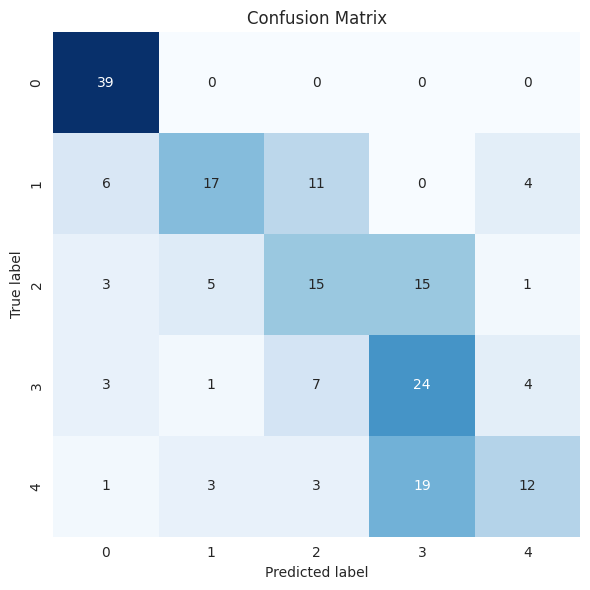

Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        39
           1       0.65      0.45      0.53        38
           2       0.42      0.38      0.40        39
           3       0.41      0.62      0.49        39
           4       0.57      0.32      0.41        38

    accuracy                           0.55       193
   macro avg       0.56      0.55      0.54       193
weighted avg       0.56      0.55      0.54       193

Epoch 22/50
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.8202, Accuracy: 0.6711


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 1.0393, Accuracy: 0.5440
🗑️ Deleted old model file: model_epoch_21.pth
✅ Best model weights saved to model_epoch_22.pth.
Epoch 23/50
--------------------------------------------------
Training Loss: 0.8001, Accuracy: 0.6948
Validation Loss: 1.0311, Accuracy: 0.5648
🗑️ Deleted old model file: model_epoch_22.pth
✅ Best model weights saved to model_epoch_23.pth.
Epoch 24/50
--------------------------------------------------
Training Loss: 0.7640, Accuracy: 0.7081
Validation Loss: 1.0228, Accuracy: 0.5648
🗑️ Deleted old model file: model_epoch_23.pth
✅ Best model weights saved to model_epoch_24.pth.
Epoch 25/50
--------------------------------------------------
Training Loss: 0.7739, Accuracy: 0.7052
Validation Loss: 1.0180, Accuracy: 0.5648
🗑️ Deleted old model file: model_epoch_24.pth
✅ Best model weights saved to model_epoch_25.pth.
Epoch 26/50
--------------------------------------------------
Training Loss: 0.7485, Accuracy: 0.7170
Validation Loss: 1.0184, Accuracy: 0

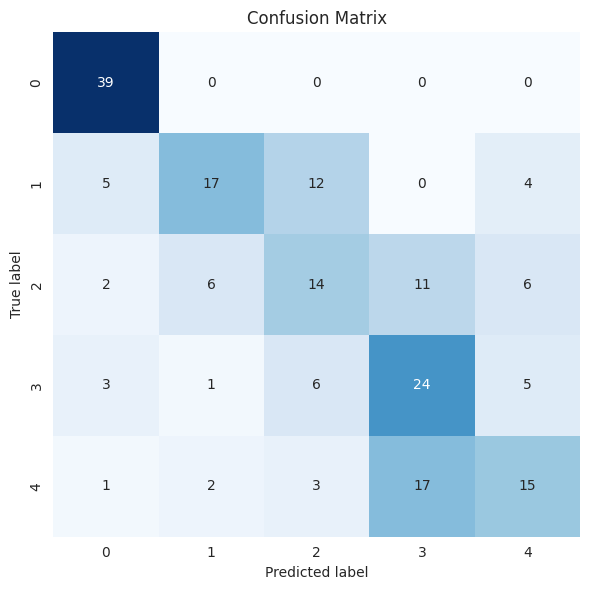

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        39
           1       0.65      0.45      0.53        38
           2       0.40      0.36      0.38        39
           3       0.46      0.62      0.53        39
           4       0.50      0.39      0.44        38

    accuracy                           0.56       193
   macro avg       0.56      0.56      0.55       193
weighted avg       0.56      0.56      0.55       193

Epoch 27/50
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.7456, Accuracy: 0.6859


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 1.0065, Accuracy: 0.5803
🗑️ Deleted old model file: model_epoch_25.pth
✅ Best model weights saved to model_epoch_27.pth.
Epoch 28/50
--------------------------------------------------
Training Loss: 0.7597, Accuracy: 0.6993
Validation Loss: 1.0061, Accuracy: 0.5699
🗑️ Deleted old model file: model_epoch_27.pth
✅ Best model weights saved to model_epoch_28.pth.
Epoch 29/50
--------------------------------------------------
Training Loss: 0.7457, Accuracy: 0.7037
Validation Loss: 1.0115, Accuracy: 0.5803
Epoch 30/50
--------------------------------------------------
Training Loss: 0.7035, Accuracy: 0.7556
Validation Loss: 1.0059, Accuracy: 0.5803
🗑️ Deleted old model file: model_epoch_28.pth
✅ Best model weights saved to model_epoch_30.pth.
Epoch 31/50
--------------------------------------------------
Training Loss: 0.7038, Accuracy: 0.7230
Validation Loss: 1.0001, Accuracy: 0.5855
🗑️ Deleted old model file: model_epoch_30.pth
✅ Best model weights saved to model_epoch_31

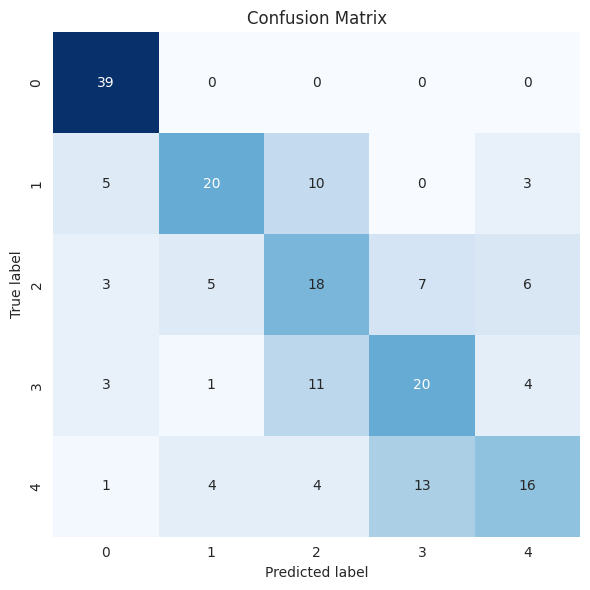

Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.87        39
           1       0.67      0.53      0.59        38
           2       0.42      0.46      0.44        39
           3       0.50      0.51      0.51        39
           4       0.55      0.42      0.48        38

    accuracy                           0.59       193
   macro avg       0.58      0.58      0.58       193
weighted avg       0.58      0.59      0.58       193

Epoch 32/50
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.7123, Accuracy: 0.7407


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 1.0045, Accuracy: 0.5751
Epoch 33/50
--------------------------------------------------
Training Loss: 0.6684, Accuracy: 0.7467
Validation Loss: 1.0031, Accuracy: 0.5855
Epoch 34/50
--------------------------------------------------
Training Loss: 0.6792, Accuracy: 0.7496
Validation Loss: 1.0053, Accuracy: 0.5751
Epoch 35/50
--------------------------------------------------
Training Loss: 0.6656, Accuracy: 0.7556
Validation Loss: 1.0010, Accuracy: 0.5751
Epoch 36/50
--------------------------------------------------
Training Loss: 0.6346, Accuracy: 0.7644
Validation Loss: 0.9993, Accuracy: 0.5803
🗑️ Deleted old model file: model_epoch_31.pth
✅ Best model weights saved to model_epoch_36.pth.


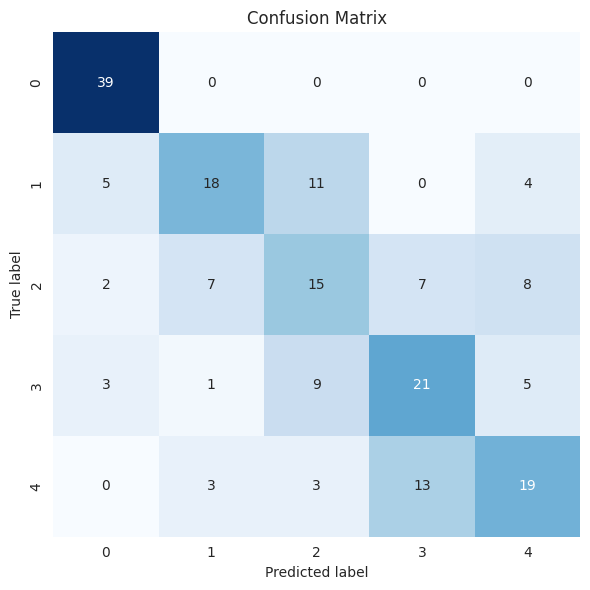

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        39
           1       0.62      0.47      0.54        38
           2       0.39      0.38      0.39        39
           3       0.51      0.54      0.53        39
           4       0.53      0.50      0.51        38

    accuracy                           0.58       193
   macro avg       0.57      0.58      0.57       193
weighted avg       0.57      0.58      0.57       193

Epoch 37/50
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.6468, Accuracy: 0.7541


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 0.9966, Accuracy: 0.5855
🗑️ Deleted old model file: model_epoch_36.pth
✅ Best model weights saved to model_epoch_37.pth.
Epoch 38/50
--------------------------------------------------
Training Loss: 0.6627, Accuracy: 0.7422
Validation Loss: 0.9975, Accuracy: 0.5803
Epoch 39/50
--------------------------------------------------
Training Loss: 0.6510, Accuracy: 0.7496
Validation Loss: 0.9989, Accuracy: 0.5959
Epoch 40/50
--------------------------------------------------
Training Loss: 0.6424, Accuracy: 0.7644
Validation Loss: 0.9970, Accuracy: 0.5959
Epoch 41/50
--------------------------------------------------
Training Loss: 0.6330, Accuracy: 0.7674
Validation Loss: 0.9982, Accuracy: 0.6062


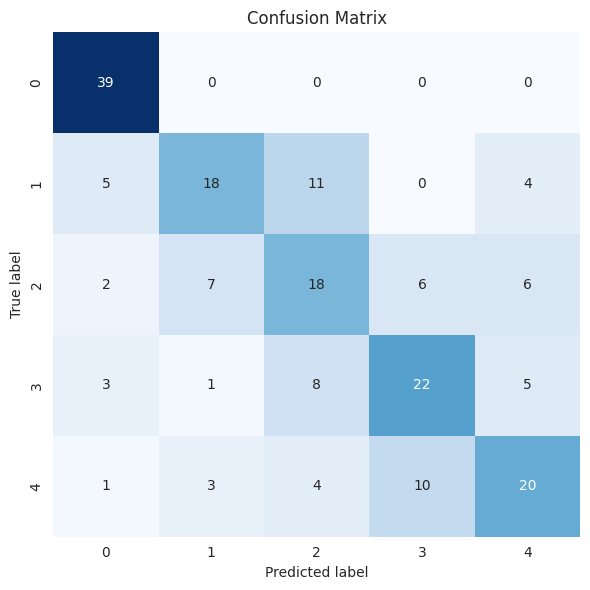

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        39
           1       0.62      0.47      0.54        38
           2       0.44      0.46      0.45        39
           3       0.58      0.56      0.57        39
           4       0.57      0.53      0.55        38

    accuracy                           0.61       193
   macro avg       0.60      0.61      0.60       193
weighted avg       0.60      0.61      0.60       193

Epoch 42/50
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.6184, Accuracy: 0.7704


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 0.9978, Accuracy: 0.6062
Epoch 43/50
--------------------------------------------------
Training Loss: 0.6506, Accuracy: 0.7570
Validation Loss: 0.9971, Accuracy: 0.6010
Epoch 44/50
--------------------------------------------------
Training Loss: 0.6235, Accuracy: 0.7659
Validation Loss: 0.9941, Accuracy: 0.5959
🗑️ Deleted old model file: model_epoch_37.pth
✅ Best model weights saved to model_epoch_44.pth.
Epoch 45/50
--------------------------------------------------
Training Loss: 0.6279, Accuracy: 0.7615
Validation Loss: 0.9949, Accuracy: 0.5959
Epoch 46/50
--------------------------------------------------
Training Loss: 0.6375, Accuracy: 0.7585
Validation Loss: 0.9943, Accuracy: 0.6010


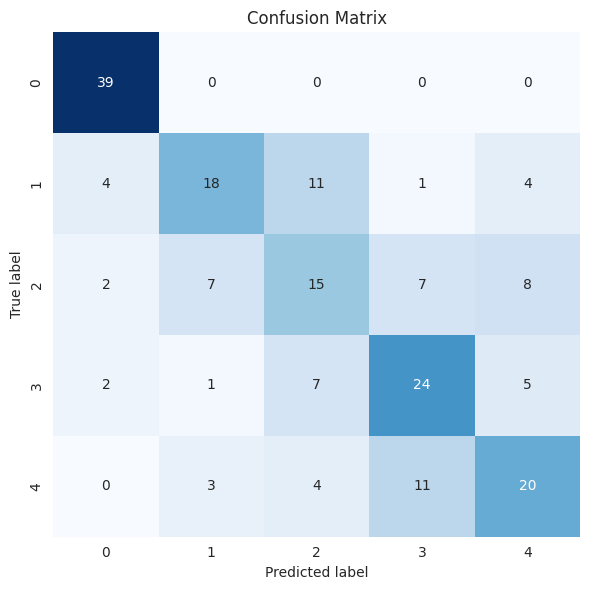

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        39
           1       0.62      0.47      0.54        38
           2       0.41      0.38      0.39        39
           3       0.56      0.62      0.59        39
           4       0.54      0.53      0.53        38

    accuracy                           0.60       193
   macro avg       0.59      0.60      0.59       193
weighted avg       0.59      0.60      0.59       193

Epoch 47/50
--------------------------------------------------


<ipython-input-19-cfa2548f3618>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.6348, Accuracy: 0.7481


<ipython-input-19-cfa2548f3618>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 0.9979, Accuracy: 0.5959
Epoch 48/50
--------------------------------------------------
Training Loss: 0.5978, Accuracy: 0.7763
Validation Loss: 0.9995, Accuracy: 0.5907
Epoch 49/50
--------------------------------------------------
Training Loss: 0.6080, Accuracy: 0.7630
Validation Loss: 1.0000, Accuracy: 0.5907
Epoch 50/50
--------------------------------------------------
Training Loss: 0.5861, Accuracy: 0.7822
Validation Loss: 0.9955, Accuracy: 0.6010
Loading best model weights...


<ipython-input-19-cfa2548f3618>:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_epoch_{}.pth".format(early_stopping.best_epoch + 1

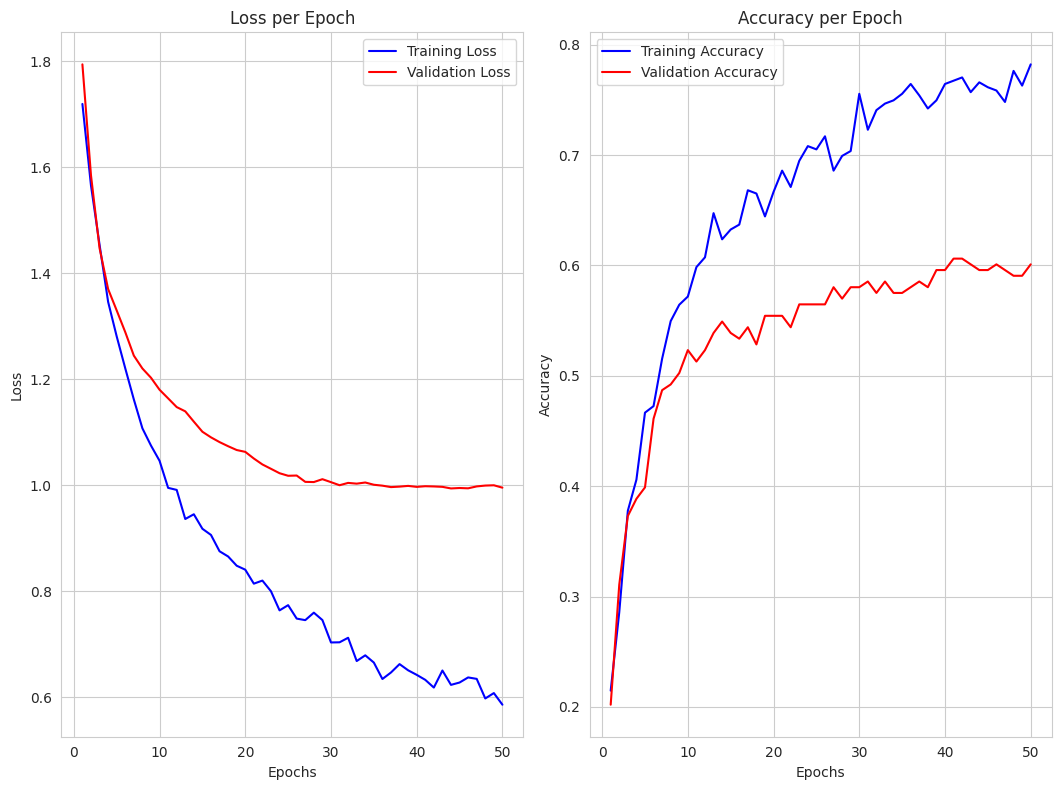

In [44]:

# ===========================================================
# Example: Training Loop (Use Early Stopping and Model Training)
# ===========================================================
early_stopping = EarlyStopping(patience=7, verbose=True, delta=0)
model_name_prefix = "model_ResNet18"  # Change dynamically for each model type

# Assuming you have a `train_and_validate` function defined elsewhere
trained_model = train_and_validate(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    loss_fn,
    epochs=50,
    device=device,
    early_stopping=early_stopping,
    model_name_prefix=model_name_prefix
)

<ipython-input-20-e6c803e16848>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Test Loss: 1.1262, Test Accuracy: 0.5773
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.95      0.82        19
           1       0.62      0.25      0.36        20
           2       0.43      0.63      0.51        19
           3       0.52      0.58      0.55        19
           4       0.67      0.50      0.57        20

    accuracy                           0.58        97
   macro avg       0.59      0.58      0.56        97
weighted avg       0.59      0.58      0.56        97



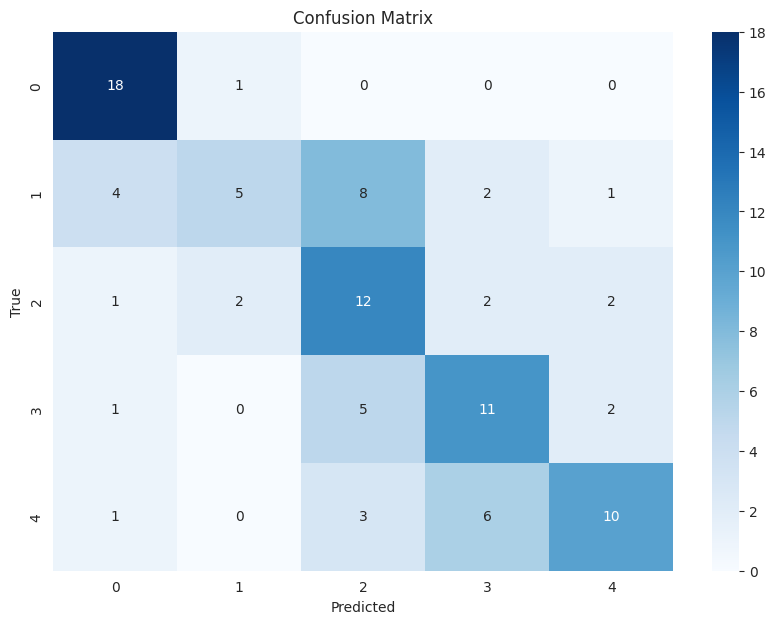

In [45]:
test_model(model, test_loader, loss_fn, device, num_classes=5)

## Hybrid Modeling(resnext50 + SE attention block)

In [63]:
import torch
import torch.nn as nn
import torchvision.models as models

# --- Define the SE (Squeeze-and-Excitation) Block ---
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)  # [batch, channel]
        y = self.fc(y).view(b, c, 1, 1)  # [batch, channel, 1, 1]
        return x * y.expand_as(x)        # Channel-wise attention

# --- Define the ResNeXt Model with SE Block (Training from Scratch) ---
class ResNeXtWithSE(nn.Module):
    def __init__(self, num_classes=4, reduction=16, dropout_prob=0.3):  # Change num_classes=1 -> num_classes=N
        super(ResNeXtWithSE, self).__init__()

        # Load ResNeXt50_32x4d **without pre-trained weights** (training from scratch)
        self.base = models.resnext50_32x4d(pretrained=False)  # pretrained=False to train from scratch

        # Keep all layers trainable (not freezing anything)

        # Get feature size from original FC layer
        in_features = self.base.fc.in_features

        # Remove original FC layer and add SE block
        self.base.fc = nn.Identity()  # Remove FC layer, output: [batch, in_features]

        # Add SE attention block
        self.se = SEBlock(channel=in_features, reduction=reduction)

        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Linear(512, num_classes)  # Output shape: (batch_size, num_classes)
        )

    def forward(self, x):
        features = self.base(x)  # Extract features from ResNeXt
        if features.dim() == 4:
            features = self.se(features)  # Apply SE block
            features = features.view(features.size(0), -1)  # Flatten

        out = self.classifier(features)  # Classification head
        return out  # No need for .view(-1), keep (batch_size, num_classes)


In [66]:

torch.cuda.empty_cache()


In [67]:
# Create a dummy input tensor on the same device
input_tensor = torch.randn(1, 3, 224, 224).to(device)

# Print model summary
summary(model, (3, 224, 224))


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 2640 has 14.73 GiB memory in use. Of the allocated memory 14.46 GiB is allocated by PyTorch, and 130.59 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [65]:

# ===========================================================
# Example: Training Loop (Use Early Stopping and Model Training)
# ===========================================================
early_stopping = EarlyStopping(patience=7, verbose=True, delta=0)
model_name_prefix = "model_ResNext_attention"  # Change dynamically for each model type

# Assuming you have a `train_and_validate` function defined elsewhere
trained_model = train_and_validate(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    loss_fn,
    epochs=50,
    device=device,
    early_stopping=early_stopping,
    model_name_prefix=model_name_prefix
)

Epoch 1/50
--------------------------------------------------


OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 2640 has 14.73 GiB memory in use. Of the allocated memory 14.46 GiB is allocated by PyTorch, and 132.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
#LOAD MODEL



def load_finetuned_attention_model(checkpoint_path, device, num_classes=1, reduction=16, dropout_prob=0.3):
    model = FineTunedResNeXtWithAttention(
        num_classes=num_classes,
        reduction=reduction,
        dropout_prob=dropout_prob
    )

    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()
    return model

# Usage Example
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_path = r"O:\O drive\AI\my project\medical image projects\breasthist\notebook model2\resnext50_32_attention_epoch_38.pth"

model = load_finetuned_attention_model(checkpoint_path, device)
print("Fine-tuned attention model loaded successfully!")


In [ ]:
test_model(model, test_loader, loss_fn, device, num_classes=5)